In [1]:
import symnum
import symnum.numpy as snp
import simsde
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

Define drift and diffusion coefficient functions for stochastic differential equation system

$$
\begin{aligned}
 \left[ \begin{array}{c} 
    dS_t \\[0.1cm] 
    dI_t \\[0.1cm] 
    dC_t
\end{array} \right] 
 = \left[ \!\! \begin{array}{c}  
    - \tfrac{C_t S_t I_t }{N} \\[0.1cm] 
    \tfrac{C_t S_t I_t }{N} - \lambda I_t \\[0.1cm]
    \Bigl( \alpha  (\beta - \log C_t) + \tfrac{\sigma^2}{2}  \Bigr) C_t 
\end{array} \!\! 
  \right] dt  
 +  
  \left[ \!\!  \begin{array}{ccc}  
  \sqrt{\tfrac{C_t S_t I_t }{N}} & 0 & 0 \\[0.1cm]
  - \sqrt{\tfrac{C_t S_t I_t }{N}} & \sqrt{\lambda I_t} & 0 \\[0.1cm]
  0 & 0 & \sigma \\[0.1cm]
  \end{array}
  \!\! \right] \, 
  \left[ \begin{array}{c}
   d B_{1,t} \\[0.1cm] 
   d B_{2,t} \\[0.1cm]
   d B_{3,t} \\
   \end{array}
  \right],
\end{aligned}
$$

in terms of log-transformed state $X_t = [\log S_t, \log I_t, \log C_t]^\top$

In [2]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N 
        - snp.exp(log_S + log_C - log_I) / (2 * N) 
        - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [
            -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 
            snp.sqrt(λ) * snp.exp(-log_I / 2), 
            0
        ],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

Define functions for generating from prior distribution over parameters $\theta$ and initial state $x_0$ given indepedent standard normal vectors $u$ and $v_0$.

In [3]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763.,  # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])

Assume observations of infected indviduals $I$ state component - as `x_seq[:, 1]` correspond to logarithm of this quantity we compute the exponential

In [4]:
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])

Define a function to determine quantities traces are generated for during MCMC sampling

In [5]:
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "log C(0)": x_0[2]}

Define helper functions for creating functions to simulating state sequences from model and compute log posterior density function and its gradient for inference.

In [6]:
def get_generate_x_seq_function(step_func, lower_bound=-500):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }

Create integrator step functions for Euler-Maruyama and weak 2nd order scheme and create corresponding function for generating state sequences

In [7]:
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
         simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff),
         2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}

Define observation sequence using infected individuals data from figure in [_Influenza in a boarding school_ (British Medical Journal, 1 586-590)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1603269/pdf/brmedj00115-0064.pdf)

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Observed infected individuals')]

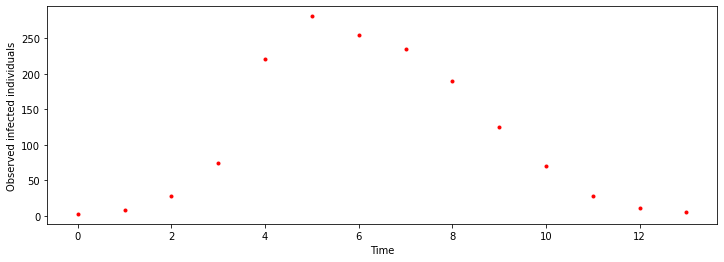

In [8]:
dt_simulation = 0.001 

y_obs = np.array([3, 8, 28, 75, 221, 281, 255, 235, 190, 125, 70, 28, 12, 5])
dt_observation = 1.
t_max = (len(y_obs) - 1) * dt_observation
t_obs = np.arange(int(t_max / dt_observation) + 1) * dt_observation  

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_obs, y_obs, 'r.')
ax.set(xlabel='Time', ylabel="Observed infected individuals")

Run MCMC to estimate posterior distributions using both Euler-Maruyama and weak order 2 scheme with time step $\delta_M = 0.05$ plus baseline results using Euler-Maruyama with time step $\delta_M = 0.001$

method=euler_maruyama, dt=0.05


Sampling stage: Adaptive warm up [02:15] > Main non-adaptive [05:31]

Chain 1/4: 100%|██████████|1000/1000 [05:30<00:00, 3.03it/s, n_step=1.02e+03, accept_stat=0.847]

Chain 2/4: 100%|██████████|1000/1000 [05:30<00:00, 3.02it/s, n_step=1.02e+03, accept_stat=0.849]

Chain 3/4: 100%|██████████|1000/1000 [05:29<00:00, 3.04it/s, n_step=1.01e+03, accept_stat=0.846]

Chain 4/4: 100%|██████████|1000/1000 [05:30<00:00, 3.02it/s, n_step=1.01e+03, accept_stat=0.852]

/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)
/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)
/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.053,2.517,0.049,5.706,0.046,0.035,4019.0,2986.0,1.0
β,0.577,0.177,0.295,0.945,0.003,0.002,4370.0,3121.0,1.0
σ,0.218,0.258,0.002,0.639,0.006,0.004,1521.0,2956.0,1.0
λ,0.493,0.021,0.453,0.529,0.000,0.000,8685.0,3119.0,1.0
log C(0),0.412,0.744,-1.115,1.734,0.011,0.011,4890.0,3169.0,1.0


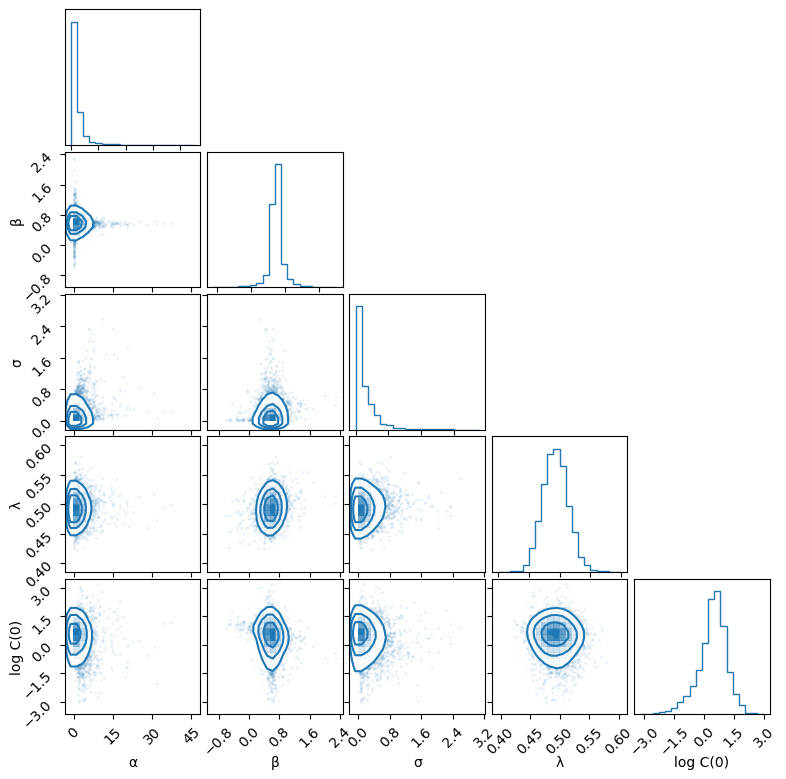

method=weak_order_2, dt=0.05


Sampling stage: Adaptive warm up [03:40] > Main non-adaptive [09:16]

Chain 1/4: 100%|██████████|1000/1000 [09:13<00:00, 1.81it/s, n_step=1.01e+03, accept_stat=0.884]

Chain 2/4: 100%|██████████|1000/1000 [09:15<00:00, 1.80it/s, n_step=1.01e+03, accept_stat=0.884]

Chain 3/4: 100%|██████████|1000/1000 [09:12<00:00, 1.81it/s, n_step=1.01e+03, accept_stat=0.871]

Chain 4/4: 100%|██████████|1000/1000 [09:15<00:00, 1.80it/s, n_step=1.01e+03, accept_stat=0.880]

/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.008,2.211,0.038,5.425,0.036,0.026,4147.0,3140.0,1.0
β,0.587,0.176,0.256,0.880,0.003,0.002,4638.0,3110.0,1.0
σ,0.205,0.243,0.001,0.653,0.006,0.004,1748.0,2403.0,1.0
λ,0.482,0.019,0.446,0.518,0.000,0.000,8466.0,2641.0,1.0
log C(0),0.409,0.728,-1.161,1.625,0.010,0.010,5243.0,2929.0,1.0


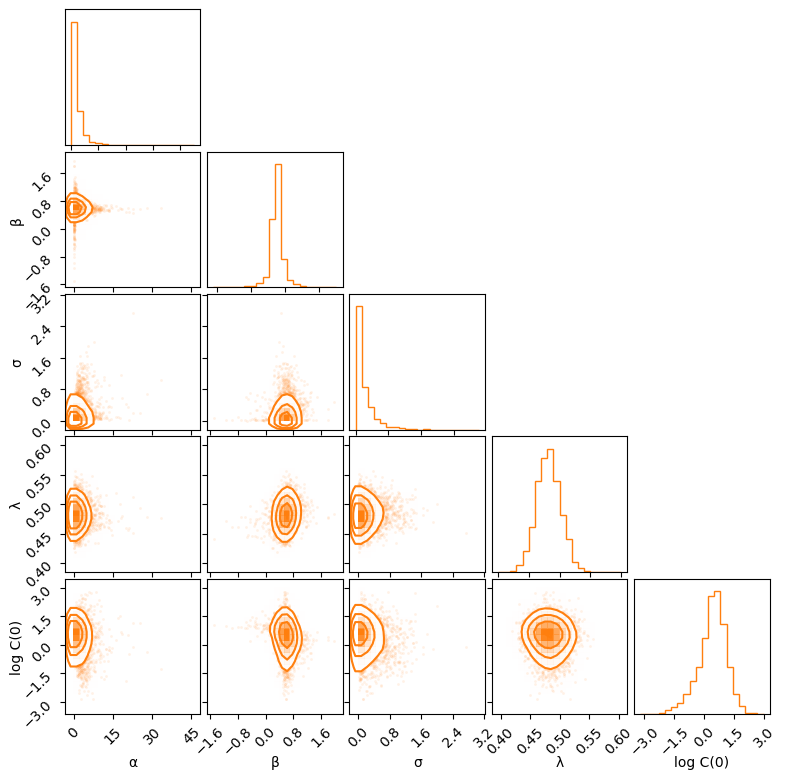

method=euler_maruyama, dt=0.001


Sampling stage: Adaptive warm up [2:33:28] > Main non-adaptive [6:25:04]

Chain 1/4: 100%|██████████|1000/1000 [6:18:44<00:00, 22.72s/it, n_step=1.01e+03, accept_stat=0.845]

Chain 2/4: 100%|██████████|1000/1000 [6:17:50<00:00, 22.67s/it, n_step=1.01e+03, accept_stat=0.852]

Chain 3/4: 100%|██████████|1000/1000 [6:24:23<00:00, 23.06s/it, n_step=1.01e+03, accept_stat=0.851]

Chain 4/4: 100%|██████████|1000/1000 [6:25:03<00:00, 23.10s/it, n_step=1.01e+03, accept_stat=0.839]

/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)
/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.033,2.237,0.024,5.404,0.040,0.028,3742.0,3117.0,1.0
β,0.600,0.175,0.302,0.941,0.003,0.002,4084.0,3116.0,1.0
σ,0.216,0.251,0.002,0.657,0.006,0.004,1722.0,2289.0,1.0
λ,0.483,0.020,0.446,0.521,0.000,0.000,7527.0,3243.0,1.0
log C(0),0.394,0.739,-1.112,1.703,0.011,0.011,4958.0,3101.0,1.0


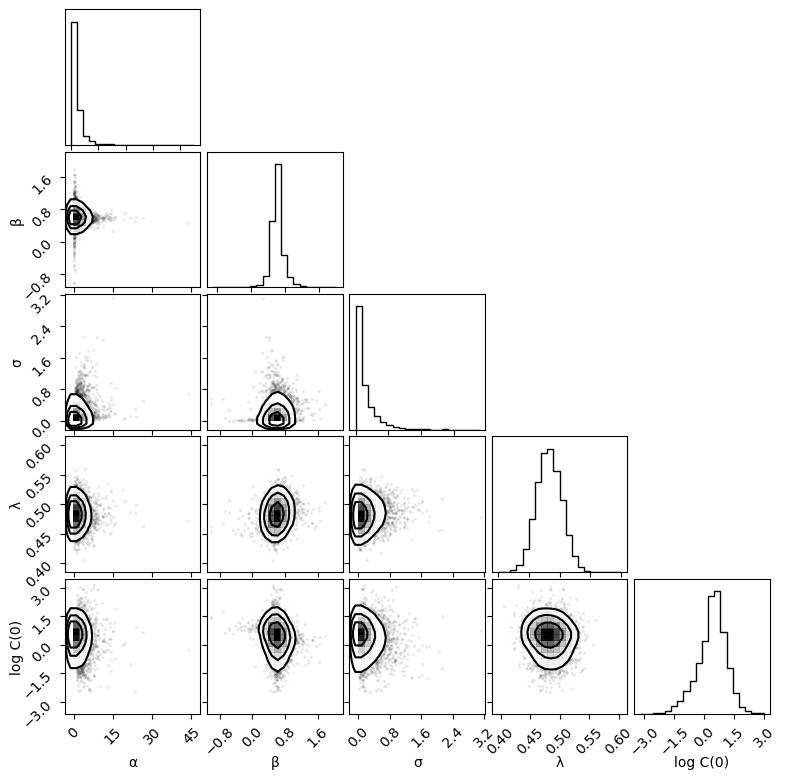

In [9]:
n_chain = 4
n_warm_up_iter = 500
n_main_iter = 1000
dt_inference = 0.05
dt_baseline = 0.001

common_kwargs = {
     "generate_θ": generate_θ,
     "generate_x_0": generate_x_0,
     "obs_func": obs_func,
     "dim_u": dim_u,
     "dim_v_0": dim_v_0,
     "obs_noise_std": 5,
     "y_obs": y_obs
}

traces = {}

for method, dt, color in [
    ("euler_maruyama", dt_inference, "C0"), 
    ("weak_order_2", dt_inference, "C1"), 
    ("euler_maruyama", dt_baseline, "black")
]:
    print(f"method={method}, dt={dt}")
    t_seq_inference = np.arange(int(t_max / dt) + 1) * dt                                                                        
    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq=generate_x_seq_functions[method],
        t_seq=t_seq_inference,
        obs_time_indices=slice(0, None, int(dt_observation / dt)),
        **common_kwargs
    )
    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[method][1] * (len(t_seq_inference) - 1)
    )
    rng = np.random.default_rng(20221111)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [mici.adapters.DualAveragingStepSizeAdapter(0.8)]
    init_states = []
    while len(init_states) < n_chain:
        q = rng.standard_normal(dim_q)
        g, v = system._grad_neg_log_dens(q)
        if not (np.any(np.isnan(g)) or np.isnan(v)):
            init_states.append(q)
    final_states, traces[method, dt], stats = sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
        n_process=4,
    )
    summary = arviz.summary(traces[method, dt])
    fig, axes = plt.subplots(5, 5, figsize=(8, 8), dpi=100)
    corner.corner(
        traces[method, dt],
        color=f'{color}',
        range=[(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)],
        bins=20,
        smooth=1.,
        fig=fig,
        hist_kwargs={"density": True},
    )
    display(summary)
    display(fig)
    fig.savefig(f"elliptic_sir_mcmc_posterior_estimates_{method}_dt_{dt}.pdf")
    plt.close(fig)

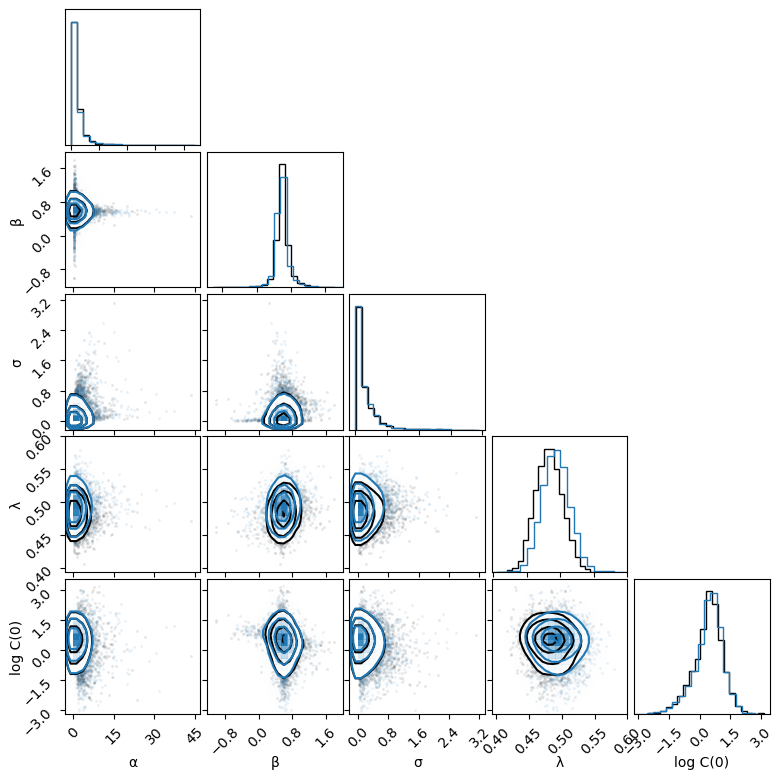

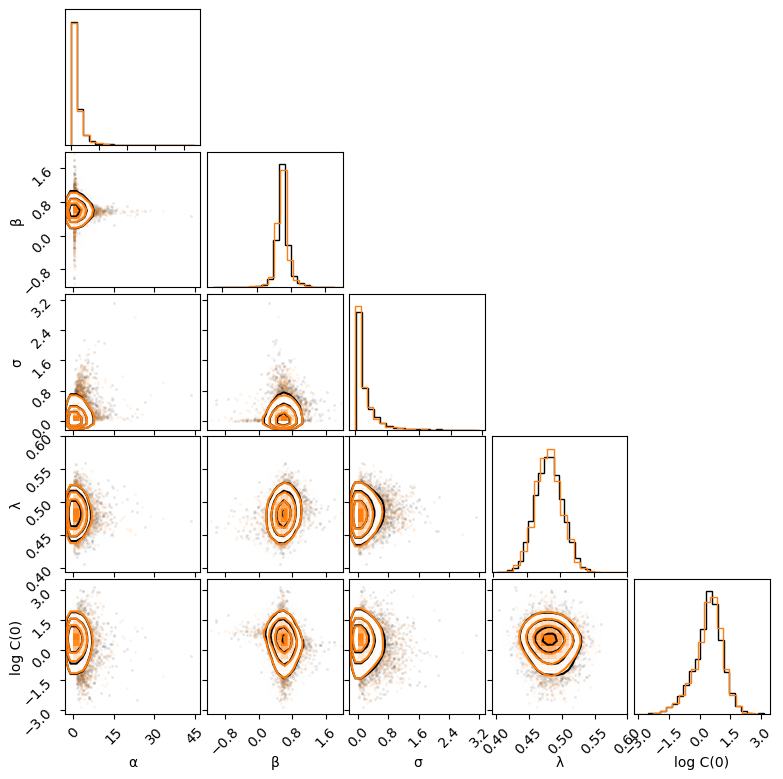

In [10]:
baseline = ("euler_maruyama", dt_baseline)
for method, dt, colour in [
    ("euler_maruyama", dt_inference, "C0"), 
    ("weak_order_2", dt_inference, "C1"), 
]:
    fig, axes = plt.subplots(5, 5, figsize=(8, 8), dpi=100)
    corner.corner(
        traces[baseline],
        color="black",
        bins=20,
        smooth=1.,
        fig=fig,
        hist_kwargs={"density": True},
    )
    corner.corner(
        traces[method, dt],
        color=f'{colour}',
        range=[(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)],
        bins=20,
        smooth=1.,
        fig=fig,
        hist_kwargs={"density": True},
    )
    display(fig)
    fig.savefig(f"elliptic_sir_mcmc_posterior_estimates_{method}_dt_{dt}_overlaid.pdf")
    plt.close(fig)